# **Data Analysis Interview Challenge with Ultimate, Inc. Data**

The attached "logins.json" file contains (simulated) timestamps of user logins in a particular geographic location. These login counts will be aggregatged based on 15­ minute time intervals, and the resulting time series of login counts will be described and visualized in ways that best characterize the underlying patterns of the demand.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import datetime
import seaborn as sns
import scipy
from google.colab import files
from scipy.stats import randint, loguniform, expon
import time
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")
style.use('seaborn-bright')

This project was initiated in Google Colab so a TPU could be utilized for randomized search cross-validation and hyperparameter tuning. Here, we will import the data set.

In [2]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving logins.json to logins.json


In [3]:
uploaded_files = files.upload()

Saving ultimate_data_challenge.json to ultimate_data_challenge.json


## **Exploratory Data Analysis**

In [4]:
# Now, we can read the .json files from desktop
df = pd.read_json('logins.json')
ddf = pd.read_json('ultimate_data_challenge.json')

df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


It appears as if this time series begins on 1-1-70 and ends on 4-13-70.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


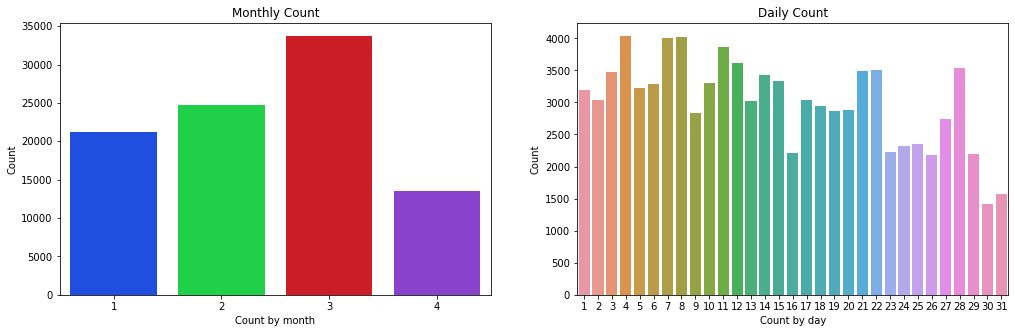

In [7]:
datetimes = list(map(lambda x: x.date(), df['login_time'].tolist())) 

months = list(map(lambda x: x.month, datetimes)) 
days = list(map(lambda x: x.day, datetimes))

df_datetimes = pd.DataFrame({'month':months, 'day':days}) 


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,5))

df1 = df_datetimes.groupby('month').count()
sns.barplot(x=df1.index.tolist(), y="day", data=df1, ax=ax1);
ax1.set(xlabel='Count by month', ylabel="Count", title="Monthly Count");


df2 = df_datetimes.groupby('day').count()
sns.barplot(x=df2.index.tolist(), y="month", data=df2, ax=ax2);
ax2.set(xlabel='Count by day', ylabel="Count", title="Daily Count");

The trend on logins appears to increase but the data we have for April is incomplete.  The count by day shows an oscillation on a weekly basis.

In [8]:
dfx = pd.DataFrame.copy(df)
dfx.set_index('login_time', inplace=True) # set index to be the timestamps, to allow aggregation
dfx['count'] = 1    # each timestamp has 1 count
dfx.sort_index(inplace=True)
df_15 = dfx.resample('15T').sum()   # aggregate by 15-min intervals
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


The aggregation of the time series in 15 minute intervals was successful.  There is clearly a pattern here as shown below.

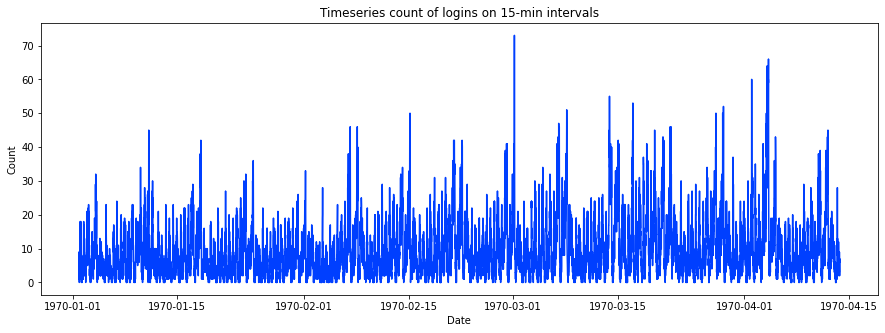

In [9]:
plt.figure(figsize=(15,5));
plt.plot(df_15);
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timeseries count of logins on 15-min intervals');

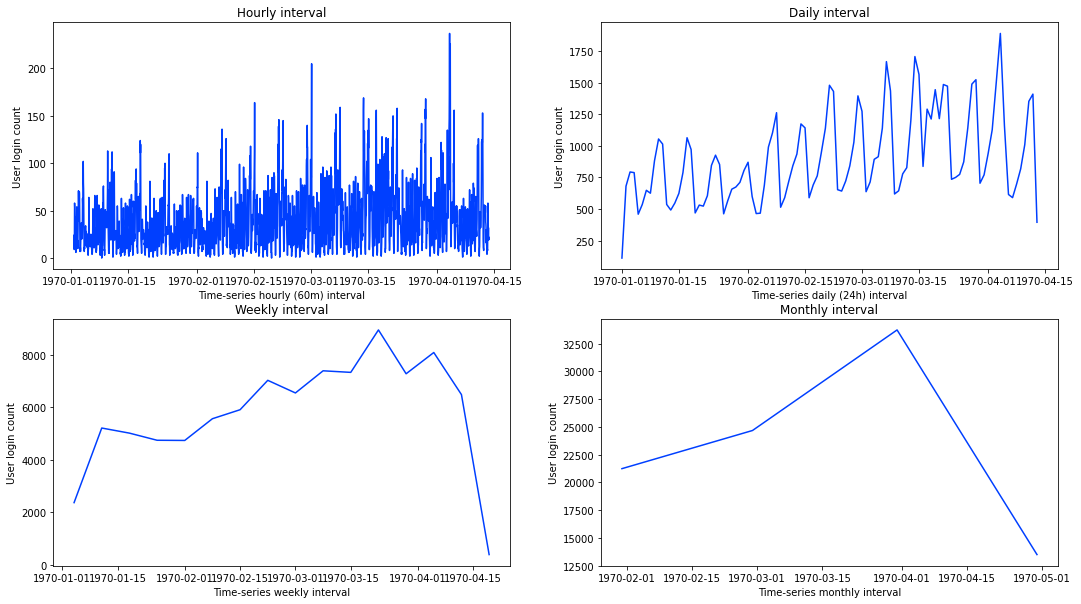

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(dfx.resample('60T').sum());
ax1.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# Daily interval
ax2.plot(dfx.resample('D').sum());
ax2.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax3.plot(dfx.resample('W').sum());
ax3.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax4.plot(dfx.resample('M').sum());
ax4.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

The daily intervals clearly show that there are peaks and troughs on a daily basis.  We will explore these fluctuations further.  As for the weekly and monthly intervals, there is clearly an upward trend until April. Let's take a look at February as we see that the 1st of February is a Sunday. Logins clearly increase early Sunday (Saturdy night) and again on the following Saturday.

In [11]:
datetime.datetime(1970, 2, 1).weekday()

6

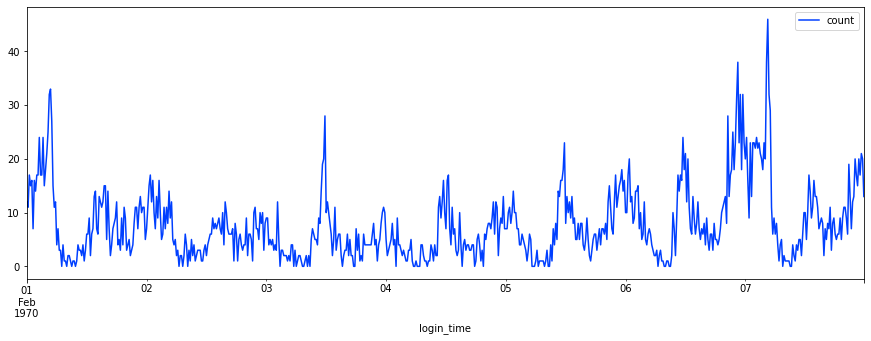

In [12]:
df_15.loc['1970-02-01':'1970-02-07'].plot(figsize=(15,5))
plt.show()

The rolling mean clearly shows the increase in activity on the weekend.

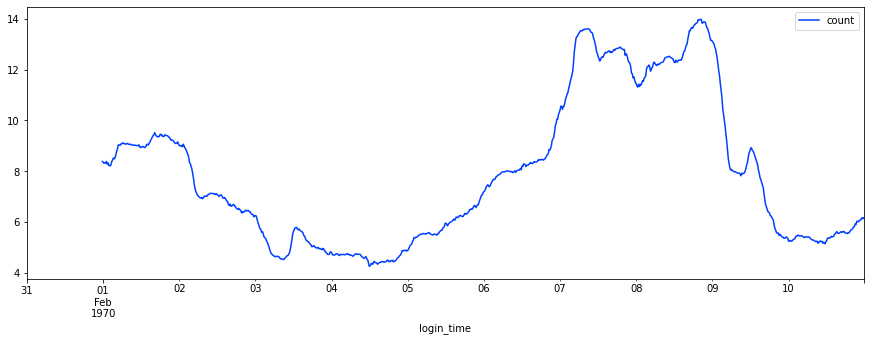

In [14]:
df_15.loc['1970-01-31':'1970-02-10'].rolling(window=96).mean().plot(figsize=(15,5))
plt.show()

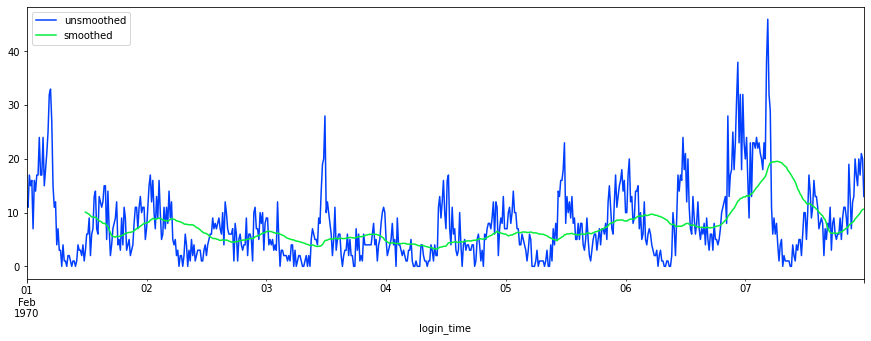

In [15]:
unsmoothed = df_15['count']['1970-02-01':'1970-02-07']
smoothed = unsmoothed.rolling(window=48).mean()
one_week = pd.DataFrame({'unsmoothed':unsmoothed, 'smoothed':smoothed})
one_week.plot(figsize=(15,5))
plt.show()

As we take a snapshot of the weekend, we see that there is increased activity around noon on Friday but a marked increase after midnight on Friday and Saturday night indicating riders probably need a ride home after closing down bars or needing rides to the airport for early flights.

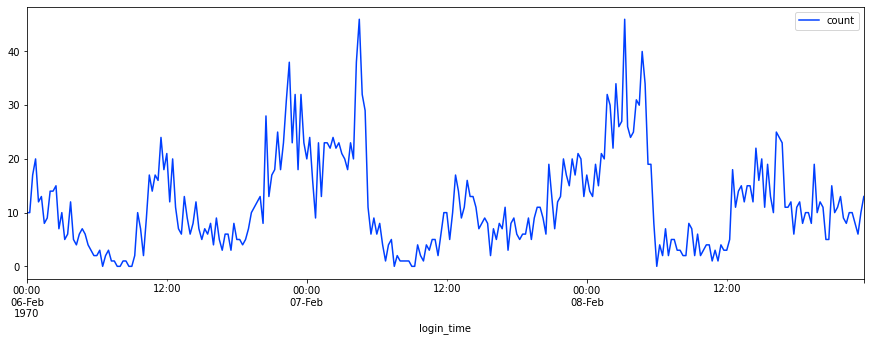

In [16]:
df_15.loc['1970-02-06':'1970-02-08'].plot(figsize=(15,5))
plt.show()

During the week on a Wednesday and Thursday, we can see that activity increases at noon but also again in the evening hours.  

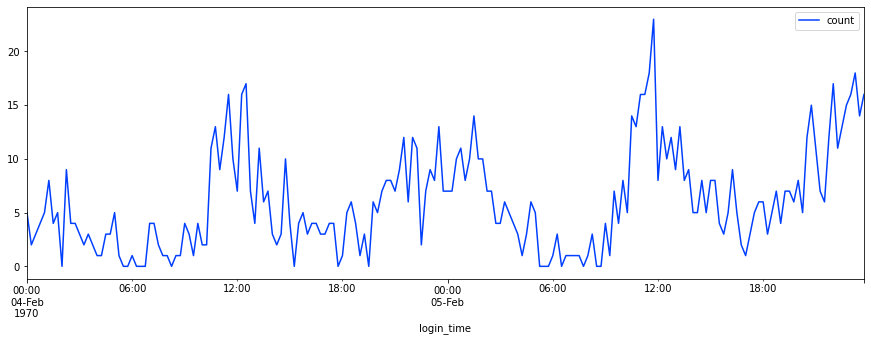

In [17]:
df_15.loc['1970-02-04':'1970-02-05'].plot(figsize=(15,5))
plt.show()

To be fair, we will take a look at January and we see that New Year's Day is on a Thursday.  We want to avoid New Year's as the activity is not typical.  We take a look at the following Wednesday and Thursday. It is roughly the same activity as above with spikes at noon and midnight.

In [18]:
date = datetime.datetime(1970, 1, 1)
date.weekday()

3

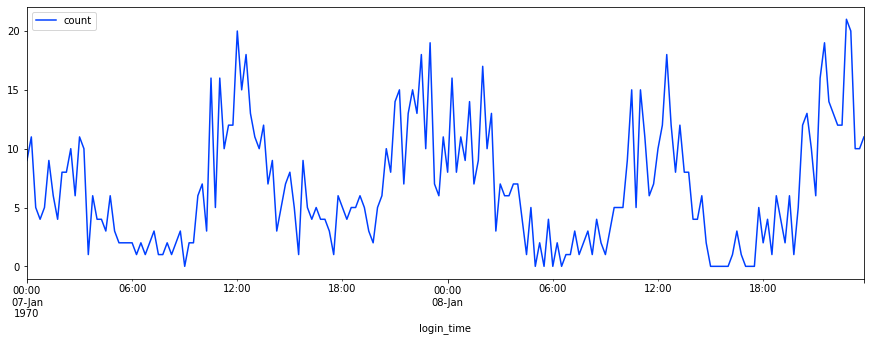

In [19]:
df_15.loc['1970-01-07':'1970-01-08' ].plot(figsize=(15,5))
plt.show()

## **Experiment and Metrics Design**

*The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.*

*However, a toll bridge, with a two­-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.*

*What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?*

More information is needed to answer this question succinctly as we must first identify the business goal for Ultimate, Inc.  Does Ultimate, Inc. want to reduce wait times for riders in one of the two cities at particular times or does Ultimate, Inc. want to increase rider retention if trips of larger distances have major influence on riders not wanting to use Ultimate?  Additionally, if we assume the bridge is the Golden Gate Bridge in San Francisco, CA, how long does it take to cross the bridge?  Maybe the toll is not the sole influence for drivers not wanting to cross the bridge.  If it takes an hour to cross the bridge and the city on the other side is not as profitable at certain times, drivers may not want to cross the bridge anyway. 

We will assume that Ultimate, Inc. wants to increase the "flux" of drivers from one city to the other.  Requests for Ultimate, Inc. could take place in one of two ways: a rider in the opposite city requests a trip from a driver in the other city and a rider in the same city requests a trip from a driver in the same city that wants to travel to the other city.  A driver typically will know both scenarios because drivers also see the destination if they have a certain status (Gold, Silver, Platinum). For instance, if a driver has one of these statuses, the app will state the time, distance, direction and city of the destination.  If a driver does not have a status of at least Gold, they will not know where they are headed. 

The key metric of this experiment should be the profit from the increase in rides that either travel from one city to the next or rides where a driver must travel to the adjacent city to pick up a rider.

*Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.*

A possible experiment is for Ultimate, Inc. to announce that the organization will reimburse drivers for the toll to travel from Gotham to Metropolis while on a trip and this activity will have to be monitored with a computer program for trips originating in one zone and traveling to another zone OR for trips where a driver will have to cross the bridge to pick up a rider.  The latter will probably not happen frequently but should still be recorded as Ultimate, Inc. will be reimbursing for the toll fares.  A particular 30 day period should be monitored and the results recorded.  

Ultimate, Inc. should make comparisons to not only the previous month but the same month of the previous year to allow for any cyclic or seasonal changes. The increase (or decrease) of these trips will carry a profit after all fees and that profit shall be examined.  

*The Null Hypothesis:* There is no significant change in the number of rides from one city or another or a ride that requires a driver to cross the bridge to pick up a rider which causes either **a reduction or no change** in profit.

*The Alternative Hypothesis:* There is significant change in the number of rides from one city or another or a ride that requires a driver to cross the bridge to pick up a rider which causes either a significant **increase** in profit.

It would be most appropriate to perform a one-sided t-test with a t-distribution because we do not know the sample mean or the standard deviation.  If these cities are even remotely large, there will be a large number of observations, even if the percentage of drivers who cross the bridge is small.  The standard error would be an estimate of the standard deviation and the degrees of freedom would be one minus the sample size.  The test statistic z is used to compute the P-value for the t distribution, the probability that a value at least as extreme as the test statistic would be observed under the null hypothesis.  Confidence intervals of 99% are commonly used now to make sure that P-values are small enough to truly reject the null hypothesis.  In other words, we would be looking for a P-value of 0.01 or less to reject the hypothesis that there was no change in the "flux" of drivers traveling across the bridge from Gotham and Metropolis while on an actual trip with a rider using the Ultimate Inc. application.

If there is no significant change in "flux" across the bridge, there may be other motivations keeping drivers from crossing it.  Additionally, promotions may need to be implemented at certain times *of need* to further motivate drivers to cross the bridge.  These promotions can look like "maps" that have additional compensation provided after so many trips and the reimbursement for bridge tolls should cease. 

If there is a significant change and an increase in profit for Ultimate, Inc. with more riders crossing the bridge, the reimbursement should continue and be reflected in the payout for the trip at the time of completion.  Drivers typically have the option to cash out anywhere from 4 times a day to after every trip and should probably receive an additional reimbursement if they have to log off and travel back to the city in which they live given they did not accept another trip in 8 hours and logged on from their home city.



## **Predictive Modeling**

Ultimate is interested in predicting rider retention. To help explore this question, a sample dataset of a cohort of users has been provided who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We will use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [31]:
display(ddf.shape)
display(ddf.info())
display(ddf.columns)

(50000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


None

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

It looks like there are 50,000 observations but there are missing values, especially for average rating of driver.  These values will need to be imputed.  The observations without phone records should probably be deleted as there are not that many of them, respectively and there is no way to know which carrier these riders had.  

In [34]:
ddf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [33]:
ddf.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


To summarize this data, there appears to be 50,000 observations and 12 features.  There does not seem to be any glaring data issues but we will analyze further.  Initially, the date colums are set as objects and they will need converted to datetime data types.  

In [35]:
ddf.last_trip_date = pd.to_datetime(ddf.last_trip_date)
ddf.signup_date = pd.to_datetime(ddf.signup_date)

In [36]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [37]:
ddf['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

### **Feature Engineering**

It appears that this data runs from 1-1-2014 to 7-1-2014 and we will use the last trip date to determine the percentage of riders that were retained in the last 30 days and to create our target variable - 'retained.'

In [38]:
fraction_retained = (ddf.last_trip_date >= '2014-06-01').sum() / (ddf.last_trip_date >= '2014-06-01').count()
fraction_retained

0.37608

In [39]:
ddf['retained'] = (ddf.last_trip_date >= '2014-06-01')*1

About 37.6% of riders have been retained.  This column was converted to numeric to prepare for modeling.  

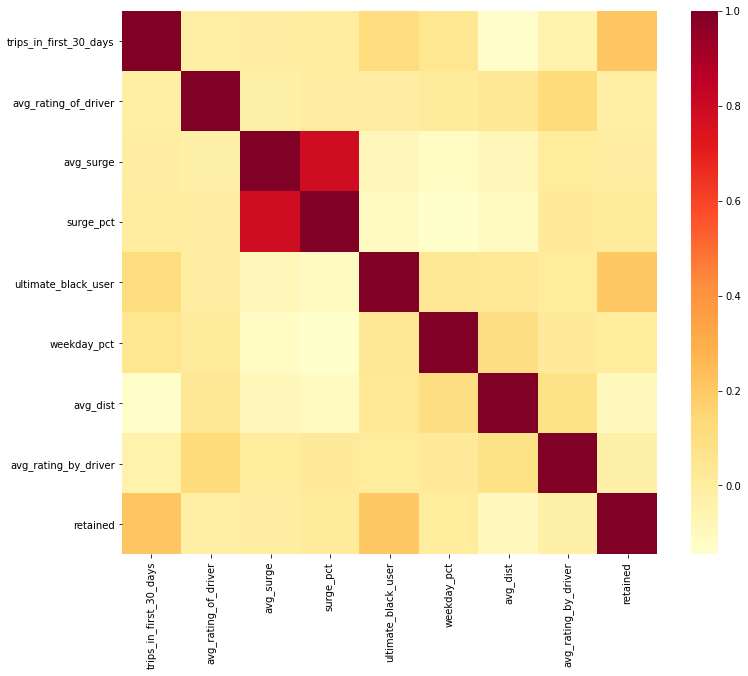

In [40]:
f, ax = plt.subplots(figsize=(12, 10))
corr = ddf.corr()
ax = sns.heatmap(corr, cmap = 'YlOrRd')
plt.show()

This heatmap shows that there are no strong correlations with the target but trips in the first 30 days and riders that use ultimate black are the most correlated.  There is one issue as average surge and surge percent are highly correlated which makes sense.  One of these colums will be removed before training.

In [41]:
#drop rows with no phone information, since we cannot infer that without building a predictive model
ddf = ddf.drop(ddf[ddf.phone.isna()==True].index,axis=0)
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    41578 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
 12  retained                49604 non-null  int64 

The cities and phones variables are categorical.  They do not contain many different values however, so utilizing one-hot encoding would not drastically increase the number of features.  These new features will be added 'city' and 'phone' will be dropped from the data set.

In [42]:
cities_hot = pd.get_dummies(ddf['city'])
phones_hot = pd.get_dummies(ddf['phone'])

In [43]:
ddf = ddf.join(cities_hot).join(phones_hot)

In [44]:
ddf.drop(['city', 'phone'], axis=1, inplace=True)

The 'retained' column will be moved back to the end.

In [45]:
# move 'retained' to the end
col_at_end = ['retained']
ddf = ddf[[c for c in ddf if c not in col_at_end]
       + [c for c in col_at_end if c in ddf]]

In [46]:
ddf.describe().iloc[:, -6:-1]

,Astapor,King's Landing,Winterfell,Android,iPhone
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,0.330881,0.202927,0.466192,0.302838,0.697162
std,0.470535,0.402183,0.498861,0.459491,0.459491
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


This data looks relatively normal.  Now, the sign up date column will be converted to numeric as well as the ultimate black user column.

In [47]:
ddf['signup_date'] = ddf['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [48]:
ddf['ultimate_black_user'] = ddf['ultimate_black_user']*1

In [49]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  49604 non-null  int64         
 1   signup_date             49604 non-null  int64         
 2   avg_rating_of_driver    41578 non-null  float64       
 3   avg_surge               49604 non-null  float64       
 4   last_trip_date          49604 non-null  datetime64[ns]
 5   surge_pct               49604 non-null  float64       
 6   ultimate_black_user     49604 non-null  int64         
 7   weekday_pct             49604 non-null  float64       
 8   avg_dist                49604 non-null  float64       
 9   avg_rating_by_driver    49406 non-null  float64       
 10  Astapor                 49604 non-null  uint8         
 11  King's Landing          49604 non-null  uint8         
 12  Winterfell              49604 non-null  uint8 

All of the data is ready for modeling except for the last trip date which will be dropped since it was used to create the target variable.  Let's take one last look at the data with a series of histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21fb8f87d0>,
      dtype=object)

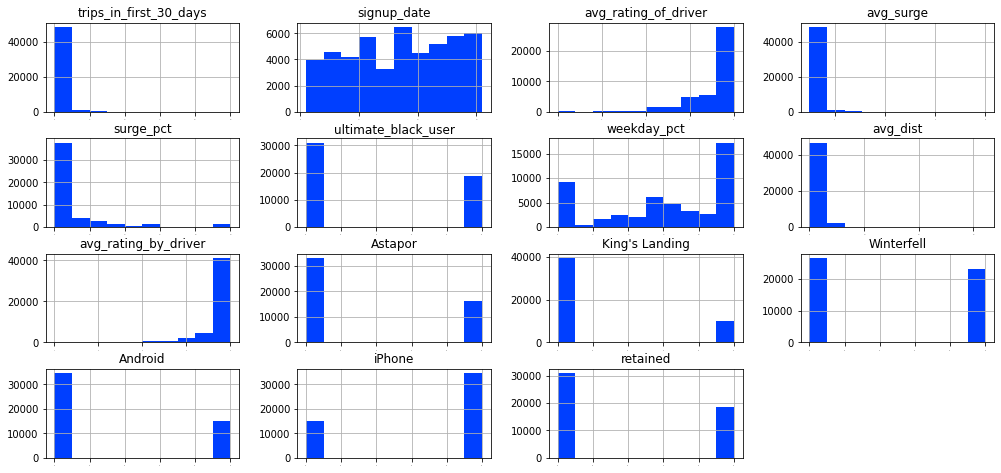

In [50]:
ddf.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8))

Now, let's check the variance of features in the data set.

In [51]:
ddf.var()

trips_in_first_30_days      14.389128
signup_date                 76.641691
avg_rating_of_driver         0.381155
avg_surge                    0.049580
surge_pct                  399.560832
ultimate_black_user          0.234433
weekday_pct               1375.389139
avg_dist                    32.145599
avg_rating_by_driver         0.199911
Astapor                      0.221403
King's Landing               0.161751
Winterfell                   0.248862
Android                      0.211132
iPhone                       0.211132
retained                     0.234728
dtype: float64

The variance for surge_pct and weekday_pct are really high.  We will be dropping surge_pct because it is highly correlated with av_surge.  We will normalize weekday_pct to reduce the variance and we will have to add a small number to those values because we cannot take the log of 0.  This will reduce the variance and we are ready for modeling.

In [57]:
ddf['weekday_pct'] = np.log(ddf['weekday_pct'] + 0.01)

In [58]:
ddf.var()

trips_in_first_30_days     14.389128
signup_date                76.641691
avg_rating_of_driver        0.381155
avg_surge                   0.049580
surge_pct                 399.560832
ultimate_black_user         0.234433
weekday_pct                11.899423
avg_dist                   32.145599
avg_rating_by_driver        0.199911
Astapor                     0.221403
King's Landing              0.161751
Winterfell                  0.248862
Android                     0.211132
iPhone                      0.211132
retained                    0.234728
dtype: float64

Most of this data is not normally distributed so we will use MinMax Scaler to scale the data.  Pipeline features for 5 machine learning models will be created below containing the imputation by the median and the MinMax Scaler.

In [59]:
np.random.seed(2346)


features = [column for column in ddf.columns.tolist() if
                    column not in ['last_trip_date', 'retained', 'surge_pct']]

transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer, features)]
)

The last trip date and surge percentage columns will be dropped due to correlation with the target and high variance, respectively.  A 15% test split will be used since we have a great deal of data to work with.

In [60]:
X = ddf.drop(['retained', 'last_trip_date', 'surge_pct'], axis=1)
y = ddf['retained']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2346, stratify=y)

Below are the names of the models we will use for modeling. Logistic Regression, K-Nearest Neighbors, Random Forest, AdaBoost and XGBoost!

In [61]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Logistic Regression', 'K Nearest Neighbors', 'Random Forest', 'AdaBoost', 'XGBoost'])

We will use Grid Search for Logistic Regression and Randomized Search for the others. This function will also let us know how much time the models take to train the data and provide essential metrics for their success and an ROC curve.

In [62]:
def train_and_score_model(model_name, estimator, param_grid=None, cv=5):
    
    
    if model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv)
    elif model_name == 'XGBoost': 
        cv = RandomizedSearchCV(estimator, param_distributions = param_grid, cv = cv)
    else:
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, random_state=None)
    
    
    
    t0 = time.time()
    cv.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    metrics.loc['Time to Train', model_name] = ttt


    y_pred = cv.predict(X_test)


    print("Accuracy with " + model_name + " on the testing set is: %.3f" % cv.score(X_test, y_test))

    metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
    
    
    y_pred_prob = cv.predict_proba(X_test)[:,1]
    metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred_prob)

    
    print(classification_report(y_test, y_pred))

    
    fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s ROC Curve' % model_name)
    plt.show()

    return cv

Now, we will define our classifiers and hyperparameter grids for the different models that will be implemented into the pipeline below.

In [63]:
#Instantiate the model/estimator

classifier_lr = LogisticRegression(solver='liblinear', random_state=2346)
classifier_knn = KNeighborsClassifier()
classifier_rf = RandomForestClassifier(random_state=2346)
classifier_ada = AdaBoostClassifier(random_state=2346)
classifier_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed=2346, scoring = "neg_mean_squared_error", n_iter = 5, verbose=1)

classifiers = [classifier_lr, classifier_knn, classifier_rf, classifier_ada, classifier_xgb]

#Specify the Hyperparameter Space

param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': np.arange(1,20),
    'classifier__leaf_size':np.arange(20,100)
}

param_grid_rf = {
                 'preprocessor__num__imputer__strategy': ['mean', 'median'], 
                 'classifier__n_estimators': np.arange(100,500),
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': np.arange(3,20),
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}

param_grid_ada = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': np.arange(100,500),
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]
}

param_grid_xgb = {
                 'classifier__max_depth': np.arange(2, 20),
                 'classifier__n_estimators': np.arange(100,500),
                 'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
                 'classifier__subsample': np.arange(0.5, 1.0),
                 'classifier__colsample_bytree': np.arange(0.4, 1.0),
                 'classifier__colsample_bylevel': np.arange(0.4, 1.0),
                 'classifier__min_child_weight': np.arange(1, 10),
                 'classifier__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0] 
}

param_grids = [param_grid_lr, param_grid_knn, param_grid_rf, param_grid_ada, param_grid_xgb]

model_names = ['Logistic Regression', 'K Nearest Neighbors', 'Random Forest', 'AdaBoost', 'XGBoost']
cv_names = ['lr_cv', 'knn_cv', 'rf_cv', 'ada_cv', 'xgb_cv']
cvs = [5, 5, 5, 5, 5]

Below is the final pipeline which will also generate very readable confusion matrices and ROC curves for each model in the pipeline. 

It takes 95.083 seconds for Logistic Regression fitting
Accuracy with Logistic Regression on the testing set is: 0.727
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      4640
           1       0.69      0.51      0.58      2801

    accuracy                           0.73      7441
   macro avg       0.71      0.68      0.69      7441
weighted avg       0.72      0.73      0.72      7441



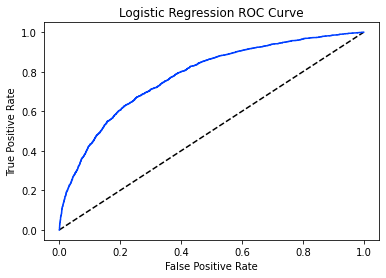

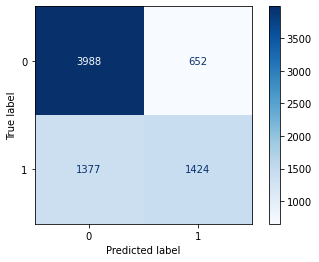

It takes 109.505 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighbors on the testing set is: 0.756
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      4640
           1       0.71      0.60      0.65      2801

    accuracy                           0.76      7441
   macro avg       0.74      0.73      0.73      7441
weighted avg       0.75      0.76      0.75      7441



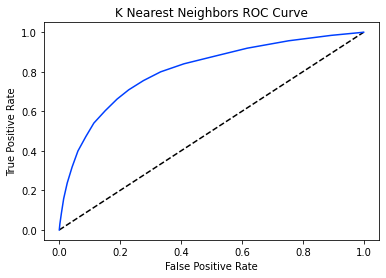

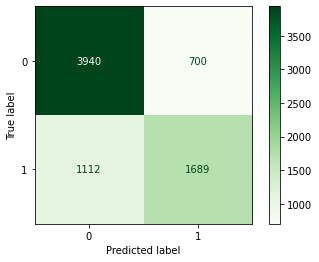

It takes 447.643 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.787
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      4640
           1       0.75      0.66      0.70      2801

    accuracy                           0.79      7441
   macro avg       0.78      0.76      0.77      7441
weighted avg       0.78      0.79      0.78      7441



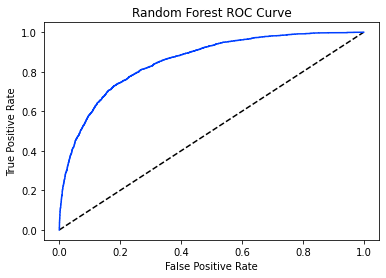

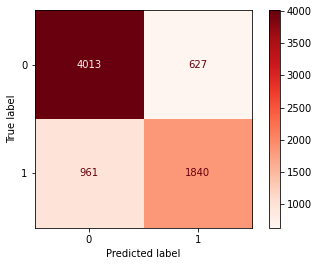

It takes 346.813 seconds for AdaBoost fitting
Accuracy with AdaBoost on the testing set is: 0.783
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      4640
           1       0.74      0.65      0.69      2801

    accuracy                           0.78      7441
   macro avg       0.77      0.76      0.76      7441
weighted avg       0.78      0.78      0.78      7441



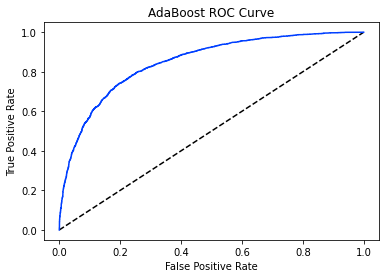

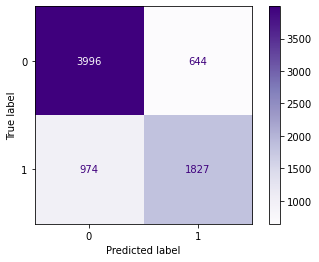

It takes 325.994 seconds for XGBoost fitting
Accuracy with XGBoost on the testing set is: 0.792
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      4640
           1       0.75      0.67      0.71      2801

    accuracy                           0.79      7441
   macro avg       0.78      0.77      0.77      7441
weighted avg       0.79      0.79      0.79      7441



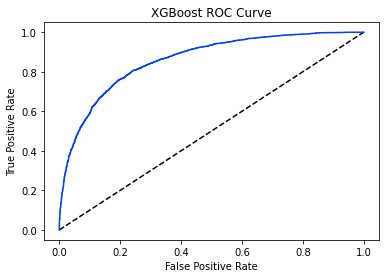

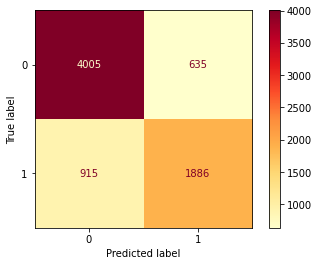

In [64]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)

plot_confusion_matrix(lr_cv, X_test, y_test, cmap = 'Blues', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_knn)])

knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)

plot_confusion_matrix(knn_cv, X_test, y_test, cmap = 'Greens', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])

rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)

plot_confusion_matrix(rf_cv, X_test, y_test, cmap = 'Reds', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_ada)])

ada_cv = train_and_score_model('AdaBoost', pipeline, param_grid_ada)

plot_confusion_matrix(ada_cv, X_test, y_test, cmap = 'Purples', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_xgb)])
xgb_cv = train_and_score_model('XGBoost', pipeline, param_grid_xgb)

plot_confusion_matrix(xgb_cv, X_test, y_test, cmap = 'YlOrRd', values_format = '')
plt.grid(False)
plt.show()

Below is a table comparing the five machine learning models.  As you can see, Extreme Gradient Boost (XGBoost) produced the highest marks in accuracy, precision, recall and area under the ROC curve.  The random forest classifier was second in all metrics just outdueling AdaBoost.

In [65]:
from pandas.plotting import table
metrics.astype(float).round(3)
model_metrics = metrics.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC']]*100
model_metrics

,Logistic Regression,K Nearest Neighbors,Random Forest,AdaBoost,XGBoost
accuracy,72.7,75.6,78.7,78.3,79.2
precision,68.6,70.7,74.6,73.9,74.8
recall,50.8,60.3,65.7,65.2,67.3
AUC,77.8,80.6,85.4,84.9,86.0


Here is a graphical representation of the performance of the five machine learning models.

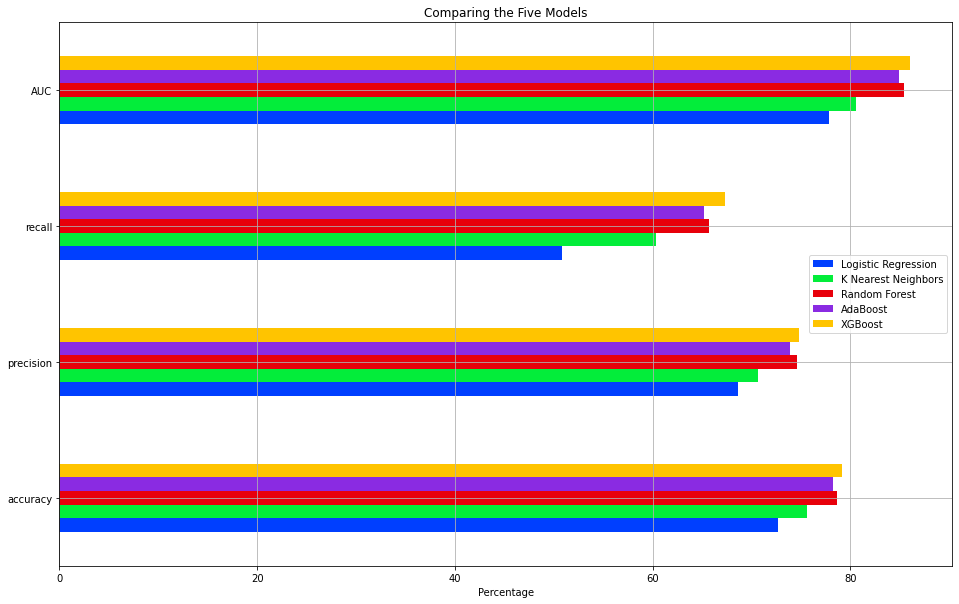

In [66]:
fig, ax = plt.subplots(figsize=(16,10))
model_metrics.plot(kind='barh', ax=ax)
ax.set_xlabel('Percentage')
ax.set_title('Comparing the Five Models')
ax.grid();

Now we will take a look at a Precision-Recall Curve for all of the models.

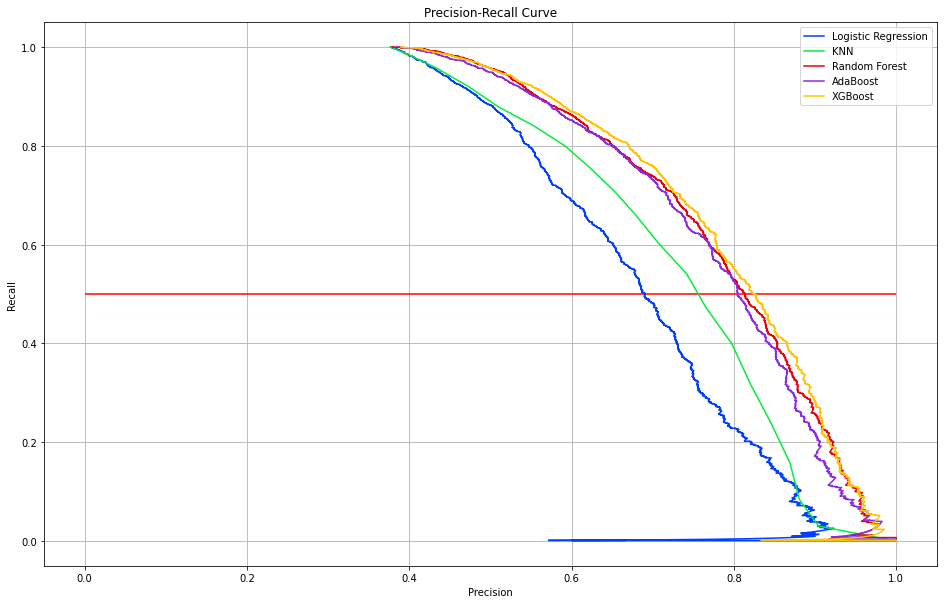

In [67]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, probas_pred=lr_cv.predict_proba(X_test)[:,1])
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true=y_test, probas_pred=knn_cv.predict_proba(X_test)[:,1])
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true=y_test, probas_pred=rf_cv.predict_proba(X_test)[:,1])
precision_ada, recall_ada, thresholds_ada = precision_recall_curve(y_true=y_test, probas_pred=ada_cv.predict_proba(X_test)[:,1])
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_true=y_test, probas_pred=xgb_cv.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(precision_lr, recall_lr, label='Logistic Regression')
ax.plot(precision_knn, recall_knn, label='KNN')
ax.plot(precision_rf, recall_rf, label='Random Forest')
ax.plot(precision_ada, recall_ada, label='AdaBoost')
ax.plot(precision_xgb, recall_xgb, label='XGBoost')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

In [68]:
xgb_cv.best_params_

{'classifier__colsample_bylevel': 0.4,
 'classifier__colsample_bytree': 0.4,
 'classifier__learning_rate': 0.2,
 'classifier__max_depth': 4,
 'classifier__min_child_weight': 7,
 'classifier__n_estimators': 448,
 'classifier__reg_lambda': 1.0,
 'classifier__subsample': 0.5}

Now, we will attempt to optimize our models and determine if we can get even higher prediciton accuracy for rider retention for one of the higher performing models.  We used imputation inside of the pipeline previously.  We will perform imputation externally and re-train our models while dropping the test set percentage in the hopes of increasing accuracy.

In [69]:
# Imputation
ddf.avg_rating_by_driver.fillna(ddf.avg_rating_by_driver.mean(),inplace=True)
ddf.avg_rating_of_driver.fillna(ddf.avg_rating_of_driver.mean(),inplace=True)

In [77]:
X = ddf.drop(['retained', 'last_trip_date', 'surge_pct'], axis=1)
y = ddf['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1111, stratify=y)

In [78]:
XGB_classifier = XGBClassifier(random_state=1111, max_depth=4, learning_rate = 0.2, min_child_weight = 7, subsample = 0.5,
                                       colsample_bylevel = 0.4, colsample_bytree = 0.4, reg_lambda = 1.0, n_estimators=448)

It takes 8.279 seconds for Extreme Gradient Boost (XGBoost) fitting
Accuracy with Extreme Gradient Boost on the testing set is: 0.783
ROC AUC score is: 0.852
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      3094
           1       0.74      0.65      0.69      1867

    accuracy                           0.78      4961
   macro avg       0.77      0.76      0.76      4961
weighted avg       0.78      0.78      0.78      4961



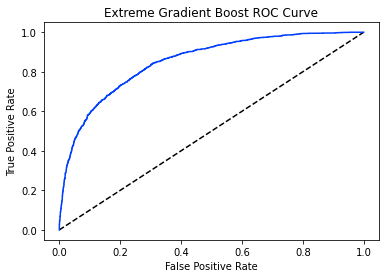

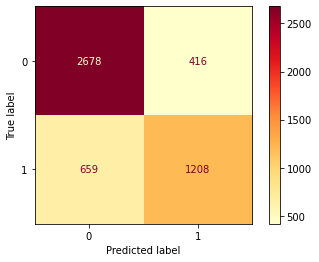

In [79]:
t0 = time.time()
XGB_classifier.fit(X_train, y_train)
ttt = time.time() - t0 
print("It takes %.3f seconds for %s fitting" % (ttt, 'Extreme Gradient Boost (XGBoost)'))


y_pred = XGB_classifier.predict(X_test)

print("Accuracy with " + 'Extreme Gradient Boost' + " on the testing set is: %.3f" % XGB_classifier.score(X_test, y_test))
    
y_pred_prob = XGB_classifier.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Extreme Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'Extreme Gradient Boost')
plt.show()

plot_confusion_matrix(XGB_classifier, X_test, y_test, cmap = 'YlOrRd', values_format = '')
plt.grid(False)
plt.show()

This XGBoost model did not do quite as well as the model before but we are going to plot feature importances to get an idea of which features are most important to our highest performing model.

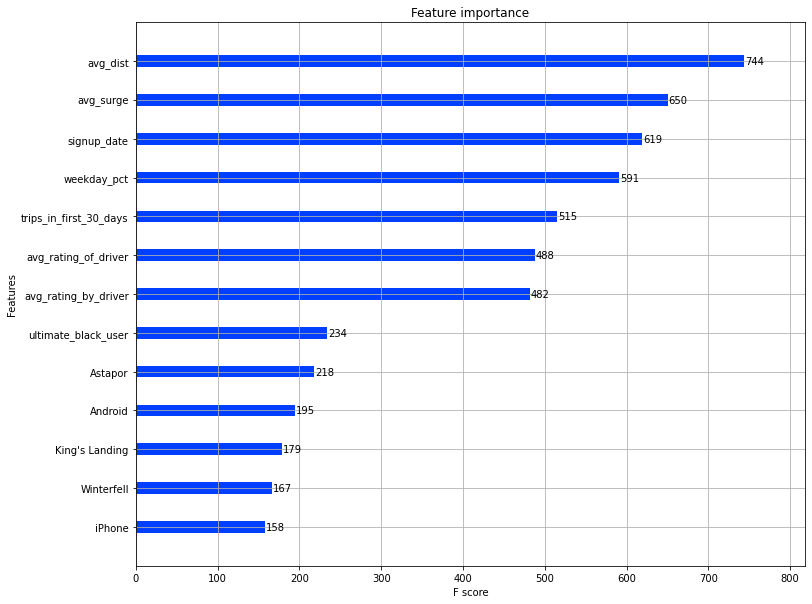

In [80]:
f, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(XGB_classifier, height=0.3, ax=ax)
plt.show()

It looks like sign up date, average distance, weekday percentage and average surge were all very significant in the XGBoost model.  We will now take a look at optimizing the random forest.

In [74]:
rf_cv.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 13,
 'classifier__max_features': 4,
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 417,
 'preprocessor__num__imputer__strategy': 'mean'}

In [75]:
rf_classifier = RandomForestClassifier(random_state=1111, criterion='gini', max_depth=13, 
                                       max_features=4, min_samples_leaf=8, min_samples_split=5, n_estimators=417)

It takes 16.870 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.783
ROC AUC score is: 0.848
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      3094
           1       0.74      0.64      0.69      1867

    accuracy                           0.78      4961
   macro avg       0.77      0.76      0.76      4961
weighted avg       0.78      0.78      0.78      4961



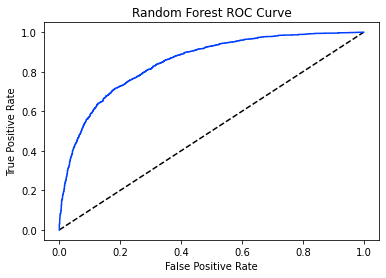

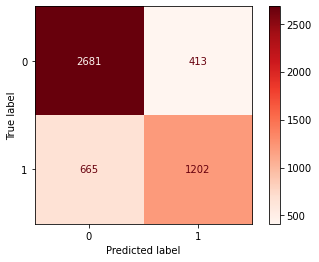

In [81]:
t0 = time.time()
rf_classifier.fit(X_train, y_train)
ttt = time.time() - t0
print("It takes %.3f seconds for %s fitting" % (ttt, 'Random Forest'))

y_pred = rf_classifier.predict(X_test)

print("Accuracy with " + 'Random Forest' + " on the testing set is: %.3f" % rf_classifier.score(X_test, y_test))
    
y_pred_prob = rf_classifier.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'Random Forest')
plt.show()

plot_confusion_matrix(rf_classifier, X_test, y_test, cmap = 'Reds', values_format = '')
plt.grid(False)
plt.show()

In [82]:
ada_cv.best_params_

{'classifier__learning_rate': 0.2,
 'classifier__n_estimators': 387,
 'preprocessor__num__imputer__strategy': 'median'}

In [83]:
AdaBoost_classifier = AdaBoostClassifier(random_state=1111, n_estimators = 387, learning_rate = 0.2)

It takes 11.220 seconds for AdaBoost fitting
Accuracy with AdaBoost on the testing set is: 0.777
ROC AUC score is: 0.842
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3094
           1       0.74      0.63      0.68      1867

    accuracy                           0.78      4961
   macro avg       0.77      0.75      0.76      4961
weighted avg       0.77      0.78      0.77      4961



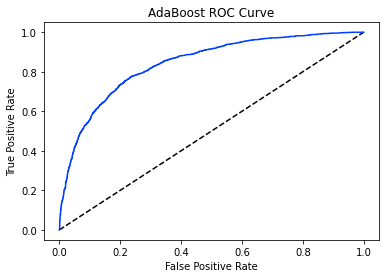

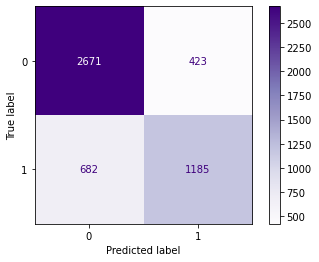

In [84]:
t0 = time.time()
AdaBoost_classifier.fit(X_train, y_train)
ttt = time.time() - t0
print("It takes %.3f seconds for %s fitting" % (ttt, 'AdaBoost'))

y_pred = AdaBoost_classifier.predict(X_test)

print("Accuracy with " + 'AdaBoost' + " on the testing set is: %.3f" % AdaBoost_classifier.score(X_test, y_test))
    
y_pred_prob = AdaBoost_classifier.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'AdaBoost')
plt.show()

plot_confusion_matrix(AdaBoost_classifier, X_test, y_test, cmap = 'Purples', values_format = '')
plt.grid(False)
plt.show()

The random forest model caught up in accuracy but still has a slightly lower area under the ROC curve.  Let's take a look at what features these models indicated as most important with a constructed model.

In [85]:
def plot_feature_importance(importance, names, model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance to Model')
  plt.ylabel('Features')

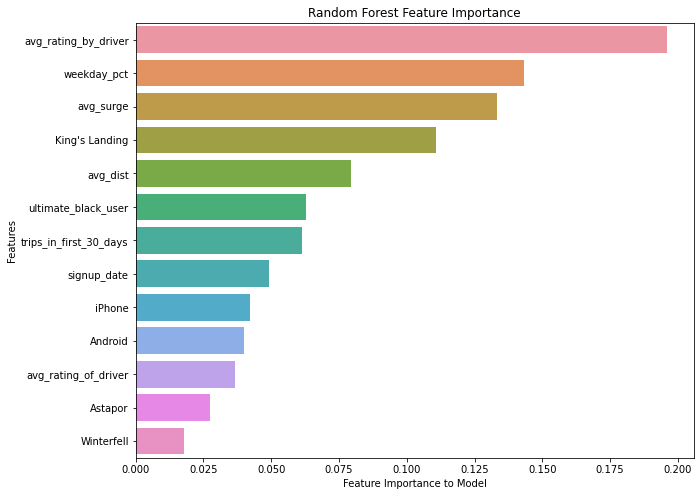

In [86]:
plot_feature_importance(rf_classifier.feature_importances_, X_train.columns,'Random Forest')

The random forest is in agreement with XGBoost with exception to the signup date.  King's Landing was also quite a bit higher here.

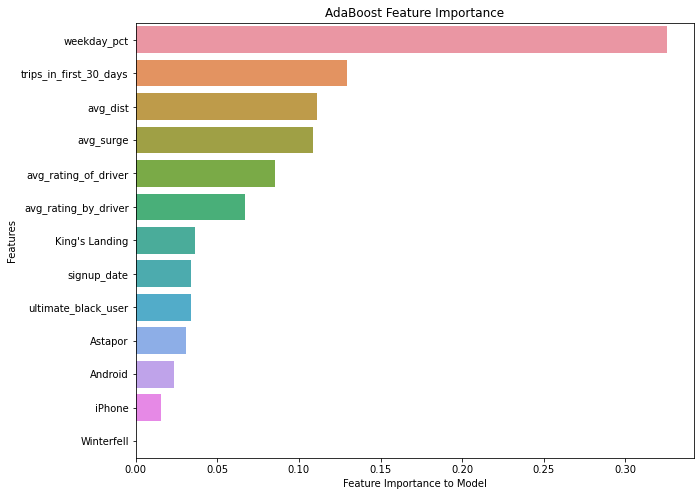

In [87]:
plot_feature_importance(AdaBoost_classifier.feature_importances_, X_train.columns,'AdaBoost')

An overwhelming preference for weekday percentage with AdaBoost with a distant second to the number of trips in the first 30 days.  Let's take a look at the average of the two and see if there is any agreement with XGBoost.

In [88]:
rf_features = rf_classifier.feature_importances_
ada_features = AdaBoost_classifier.feature_importances_

In [89]:
cols = X.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
      'AdaBoost feature importances': ada_features
    })

<Figure size 432x288 with 0 Axes>

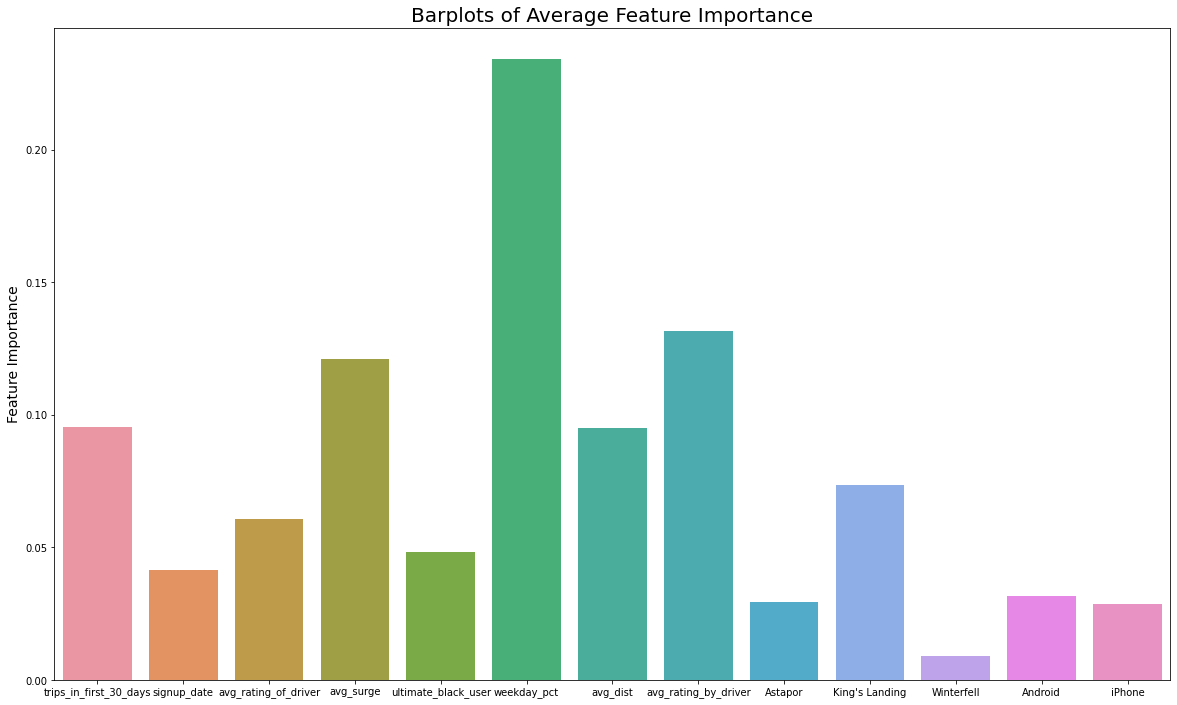

In [90]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)

yy = feature_dataframe['mean'].values
xx = feature_dataframe['features'].values

plt.figure(facecolor="white")
fig = plt.figure(figsize=(20,12))
sns.barplot(y=yy, x=xx)
plt.title('Barplots of Average Feature Importance', size = 20)
plt.ylabel('Feature Importance', size=14)
plt.show()

When we average between AdaBoost and Random Forest, we see that weekday percentage has the most importance with average rating by driver, average surge, average distance and trips in the first 30 days being significant.  King's Landing appears to be the most significant city.  Sign up date was low.  While these results are good, it is clear that XGBoost produces the best results.  There are still more hyperparameters to try so let's see if we can increase the accuracy.

In [91]:
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'max_depth': [6,8,10],
    'min_child_weight':[1,4,6],
    'subsample':[1,0.8,0.5],
    }

In [92]:
new_xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 1111, learning_rate = 0.1, n_estimators=10)

grid_search = GridSearchCV(param_grid= parameters, estimator = new_xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1111, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_delta_step': [0, 0.05], 'max_depth': [6, 8, 10],
                         'min_child_weight': [1, 4, 6],
   

In [93]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 6, 'scale_pos_weight': 0.9, 'subsample': 0.5}
0.7789575073359766


We will add these best parameters to the rest to see what kind of accuracy we can produce.

In [106]:
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 100,
                        'random_state': 1111,
                        'silent': 0,
                        'subsample': 0.5, 
                        'scale_pos_weight': 0.9, 
                        'min_child_weight': 6, 
                        'max_depth': 10, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3,
                       }

In [107]:
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9, seed=None,
              silent=0, subsample=0.5, verbosity=1)

Accuracy with the new XGBoost classifier on the testing set is: 0.847.
ROC AUC score is: 0.843
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3094
           1       0.74      0.63      0.68      1867

    accuracy                           0.78      4961
   macro avg       0.77      0.75      0.76      4961
weighted avg       0.77      0.78      0.77      4961



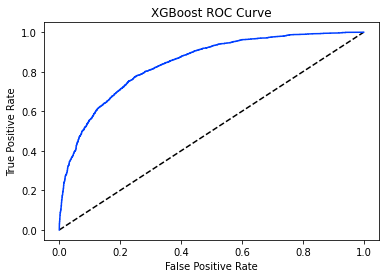

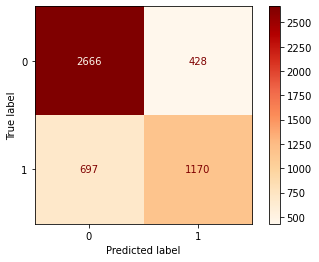

In [108]:
y_opt_pred = xg_clf_opt.predict(X_train)

score = accuracy_score(y_train, y_opt_pred)

print("Accuracy with " + 'the new XGBoost classifier' + " on the testing set is: {}.".format(round(score,3)))
    
y_pred_prob = xg_clf_opt.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='New XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'XGBoost')
plt.show()

plot_confusion_matrix(xg_clf_opt, X_test, y_test, cmap = 'OrRd', values_format = '')
plt.grid(False)
plt.show()

In [121]:
display(ddf['avg_dist'].corr(ddf['retained']))
display(ddf['avg_rating_by_driver'].corr(ddf['retained']))
display(ddf['avg_surge'].corr(ddf['retained']))
display(ddf['weekday_pct'].corr(ddf['retained']))
display(ddf['trips_in_first_30_days'].corr(ddf['retained']))
display(ddf['signup_date'].corr(ddf['retained']))
display(ddf["King's Landing"].corr(ddf['retained']))
display(ddf["Astapor"].corr(ddf['retained']))
display(ddf["Winterfell"].corr(ddf['retained']))

-0.09201417535768425

-0.02632884604163077

-0.004035017052977896

0.17514533644295396

0.21045642569145323

-0.02036590752753775

0.26239794184705745

-0.17508731122218368

-0.046400221333526115

From these correlations, we can see that weekday percentage and trips in the first 30 days are the most correlated with the target.  Average distance was indicated to be quite significant in our highest performing model, XGBoost.  We will take a look at each graphically.  

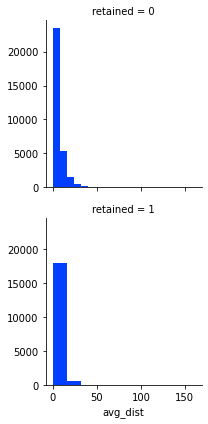

In [112]:
g = sns.FacetGrid(ddf, row='retained')
g = g.map(plt.hist, "avg_dist")

Riders who were retained had a lower average distance than riders who were not.  Ultimate should consider this since XGBoost indicated this feature as being most important in retaining riders.  Incentives could be targeted toward the higher end of this group to keep riders riding with Ultimate. 

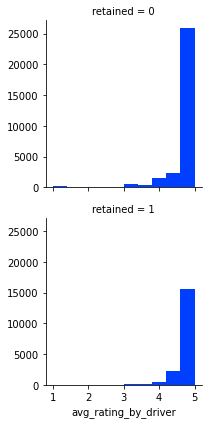

In [113]:
g = sns.FacetGrid(ddf, row='retained')
g = g.map(plt.hist, "avg_rating_by_driver")

This is bizarre as riders who are rated highly by drivers are less likely to be retained.  The correlation with the target is negative but quite small at -0.026 meaning that there may not be much relation to rider retention.  This feature was chosen to be most important by the random forest model but not XGBoost.  The other thing to note here is that the average rating may actually be higher for riders that *were* retained but the total number of riders was higher for riders who were not.  Sometimes, if a driver does not rate riders, it is automatically scored a 5, which is something to consider.

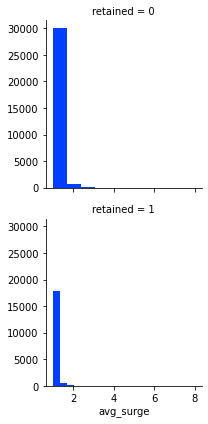

In [114]:
g = sns.FacetGrid(ddf, row='retained')
g = g.map(plt.hist, "avg_surge")

There is a negative correlation here with the target but it is almost zero.  Still, all of the models indicate this feature as very significant and the average surge seems to be higher for riders who were not retained.  Ultimate should monitor surge pricing and riders who stop using the service by sending incentives for use.

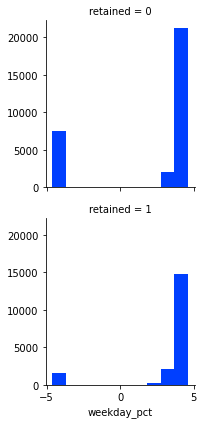

In [117]:
g = sns.FacetGrid(ddf, row='retained')
g = g.map(plt.hist, "weekday_pct")

While this feature was normalized, it is clear that there is a more "normal" distribution for riders who are retained.  This means that riders who were not retained are either using Ultimate only on weekends or not on weekends.  This feature is positively correlated with the target about 17% so Ultimate should send incentives for riders to use the service more consistently.  This could be why you see promotions from Lyft to use the service at $5 off for one week only.

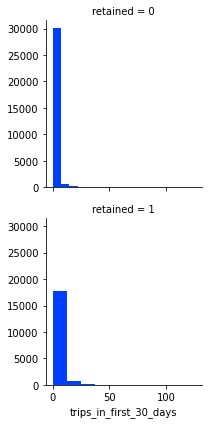

In [118]:
g = sns.FacetGrid(ddf, row='retained')
g = g.map(plt.hist, "trips_in_first_30_days")

This could be the most iteresting feature here as it is middle of the road as far as feature importance with all models but is the most positively correlated with the target.  It would seem quite obvious that if there were less rides taken in the first thirty days that the likelihood that the rider was not retained was high, as evidenced by the graphs above.  

It is story time.  My neighbors have a 5 year old girl who up until recently, has never taken a Lyft ride.  In the past week, she has taken 6!  That is because daddy's Jeep Cherokee has been to the mechanic, body shop and detailer. Here is a case where the service was really need for a short period but the family will probably continue to utilize their own transportation and not really experiencing the nightlife.  This is not to say that there was a bad experience or a competitor stole the riders away, the service was temporary for this customer base.  This feature indicates that Ultimate may want to take into account the destinations for travel instead of just an address.  This could lead to Customer Segmentation and higher insight.

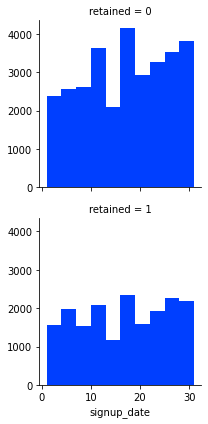

In [119]:
g = sns.FacetGrid(ddf, row='retained')
g = g.map(plt.hist, "signup_date")

XGBoost plot importance function states that this feature is important but it is not at all correlated with the target.  This feature was converted to numeric for modeling purposes and the distribution appears to be more level for those riders who were retained.  It appears that there could be some insight into signup date such as signups later in the month result in less retention.  This feature may need to be explored further.

## **Conclusion**

The optimized XGBoost model produced over an 84% accuracy providing a model suitable of determining the likelihood of retaining riders for Ultimate. It is worth noting that the initial XGBoost Model produced and area under the ROC curve of 0.86 which is over 2 percent more than the optimized model. However, the XGBoost model outperformed all models in accuracy, precision, recall and area under the ROC curve in all stages.  The Random Forest model performed very well but fell short.  Different models produced slightly different feature importances but these importances were averaged across the Random Forest and AdaBoost models to compare to XGBoost.  Approximately 37% of riders were still using Ultimate in the last 30 days after six months of use.  

Anytime there are more than 10,000 observations, XGBoost should be considered as a classifier.  XGBoost out-performs most neural networks but it needs a large amount of data to produce good results.  I chose Random Forest and AdaBoost because they are excellent binary classifiers and are handy at providing functions that produce insight on feature importance, one of the aspects that we are most concerned about.  XGBoost has a built-in plot importance function and it produced similar results as the AdaBoost model, except for signup date which may need to be explored further by Ultimate. The Random Forest model found average rating by driver to be most significant and this is an interesting result because there is a low correlation with the target and it appears that high ratings lead to lower retention.  This is not the case as if the graph is explored carefully, higher ratings exist among the lower percentage of riders that were retained.  

King's Landing seems to be the hot spot and the most significant city between the three.  There is a 26% positive correlation between King's Landing and the target. It appears that it is easier to retain riders in this area and less likely to retain riders in the areas of Astapor and Winterfell.

Random Forest, AdaBoost and XGBoost models are not sensitive to variance, handle outliers and different kinds of data well and are not prone to overfitting.  Logistic Regression and K-Nearest Neighbors (KNN) are simple models to use to get and idea of how your data is behaving.  As KNN did not preform poorly on this data set, Logistic Regression did not perform well.  Some features had high variance and there were a large number of features that had to be converted and cleaned which could explain the poor performance.  The XGBoost, Random Forest and AdaBoost models are quite valid as several hyperparameters were tuned to find the optimal accuracies for the models.  

Ultimate should monitor surge pricing and riders who stop using the service by sending incentives for use, send incentives for riders to use the service more consistently per week or per month and monitor riders' activity who travel large distances.  Ultimate may want to take into account the destinations for travel instead of just an address. This could lead to Customer Segmentation and higher insight.

